In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/fashionmnist/train-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte


# Load csv file

In [2]:
train_csv_path = '/kaggle/input/fashionmnist/fashion-mnist_train.csv'
test_csv_path = '/kaggle/input/fashionmnist/fashion-mnist_test.csv'

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# remove first column and convert to numpy array, transform to [0..1]
x_train = train_df.drop(columns=['label']).values / 255
y_train = train_df['label'].values
x_test = test_df.drop(columns=['label']).values / 255
y_test = test_df['label'].values

In [3]:
labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

# Show a sample image

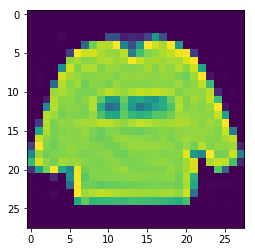

In [4]:
import matplotlib.pyplot as plt

sample_image = x_train[0,:].reshape((28,28))
plt.imshow(sample_image)


# CNN model

In [5]:
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [6]:
image_rows = 28
image_cols = 28
batch_size = 32
image_shape = (image_rows, image_cols, 1)

In [7]:
x_train = x_train.reshape(x_train.shape[0], *image_shape)
x_test = x_test.reshape(x_test.shape[0], *image_shape)

In [8]:
# augmentation
aug_train_x = np.array([np.clip(np.random.normal(0,0.1,(28,28,1)) + image,0,1) for image in x_train])
aug_train_y = np.array([y for y in y_train])

Ankle boot


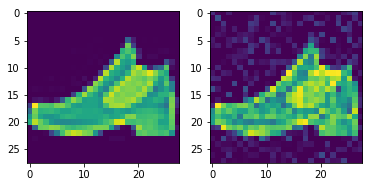

In [9]:
# show an example
index = 1
plt.subplot(121)
plt.imshow(np.squeeze(x_train[index]))
plt.subplot(122)
plt.imshow(np.squeeze(aug_train_x[index]))
print(labels[aug_train_y[index]])

In [10]:
x_train = np.concatenate((x_train, aug_train_x), axis=0)
y_train = np.concatenate((y_train, aug_train_y), axis=0)
print(len(x_train), len(y_train))

120000 120000


In [11]:
def create_model():
    inputs = Input(shape=(28,28,1))
    
    # Gated 1
    gated_x = Conv2D(filters=32, kernel_size=3, activation='sigmoid')(inputs)
    x = Conv2D(filters=32, kernel_size=3, activation='tanh')(inputs)
    x = keras.layers.multiply([x,gated_x])
    x = MaxPooling2D((2,2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # Gated 2
    gated_x = Conv2D(filters=64, kernel_size=3, activation='sigmoid', padding='same')(x)
    x = Conv2D(filters=64, kernel_size=3, activation='tanh', padding='same')(x)
    x = keras.layers.multiply([x,gated_x])
    x = MaxPooling2D((2,2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # Gated 2
    gated_x = Conv2D(filters=128, kernel_size=3, activation='sigmoid', padding='same')(x)
    x = Conv2D(filters=128, kernel_size=3, activation='tanh', padding='same')(x)
    x = keras.layers.multiply([x,gated_x])
    x = MaxPooling2D((2,2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=x)
    
    return model

In [12]:
model = create_model()

In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [14]:
max_epochs = 50
batch_size = 128
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=max_epochs,
    verbose=1,
)

Epoch 1/50
120000/120000 [==============================] - 14s 113us/step - loss: 0.5574 - accuracy: 0.7911
Epoch 2/50
120000/120000 [==============================] - 11s 91us/step - loss: 0.3910 - accuracy: 0.8543
Epoch 3/50
120000/120000 [==============================] - 11s 93us/step - loss: 0.3565 - accuracy: 0.8670
Epoch 4/50
120000/120000 [==============================] - 11s 92us/step - loss: 0.3380 - accuracy: 0.8747
Epoch 5/50
120000/120000 [==============================] - 12s 97us/step - loss: 0.3225 - accuracy: 0.8796
Epoch 6/50
120000/120000 [==============================] - 11s 93us/step - loss: 0.3157 - accuracy: 0.8829
Epoch 7/50
120000/120000 [==============================] - 11s 91us/step - loss: 0.3078 - accuracy: 0.8857
Epoch 8/50
120000/120000 [==============================] - 11s 92us/step - loss: 0.3021 - accuracy: 0.8876
Epoch 9/50
120000/120000 [==============================] - 11s 92us/step - loss: 0.2978 - accuracy: 0.8897
Epoch 10/50
120000/120000 [

In [15]:
scores = model.evaluate(x_test, y_test, verbose=1)
scores

10000/10000 [==============================] - 1s 122us/step


[0.20976854063272476, 0.9222999811172485]

# show miss classified images


In [16]:
predicts = model.predict(x_test)
y_hat = np.argmax(predicts, axis=1)
y_hat

array([0, 1, 2, ..., 8, 8, 1])

In [17]:
mis_classified_idx = y_test != y_hat
print("Total miss: {}".format(len(mis_classified_idx[mis_classified_idx])))

Total miss: 777


Predicted = Dress, Groundtruth = Coat


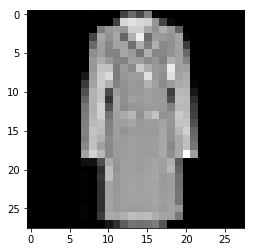

In [18]:
index = 100
image = x_test[mis_classified_idx][index]
image = np.squeeze(image)
plt.imshow(image, cmap='gray')
print('Predicted = {}, Groundtruth = {}'.format(labels[y_hat[mis_classified_idx][index]], labels[y_test[mis_classified_idx][index]]))

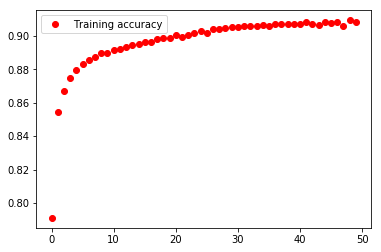

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
acc = history.history['accuracy']
epoches = range(len(acc))

plt.plot(epoches, acc, 'ro', label='Training accuracy')
plt.legend()
plt.show()